<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/02-fully-connected-networks/02_classification_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classification problems

Similar to how we can walk from linear regression to a nonlinear regression neural network, we can make the same walk from logistic regression to a nonlinear classification network. 

Recall that logistic regression is a popular algorithm for classification problems that finds a linear solution to try to separate $C$ classes.

##Setup

In [ ]:

from sklearn.datasets import make_moons

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm

import time
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from idlmam import *

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
def move_to(obj, device):
  """
  obj: the python object to move to a device, or to move its contents to a device
  device: the compute device to move objects to
  """
  if hasattr(obj, "to"):
      return obj.to(device)
  elif isinstance(obj, list):
      return [move_to(x, device) for x in obj]
  elif isinstance(obj, tuple):
      return tuple(move_to(list(obj), device))
  elif isinstance(obj, set):
      return set(move_to(list(obj), device))
  elif isinstance(obj, dict):
      to_ret = dict()
      for key, value in obj.items():
          to_ret[move_to(key, device)] = move_to(value, device)
      return to_ret
  else:
      return obj

##Toy dataset

To make our lives easier, we use the built-in `TensorDataset` object to wrap our current data. 

This only works if we can fit all of our data into RAM.

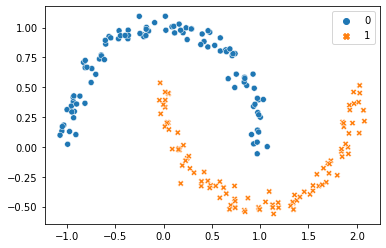

In [ ]:
# let's generate moons dataset
X, y = make_moons(n_samples=200, noise=0.05)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y)

In [ ]:
classification_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32),
    torch.tensor(y, dtype=torch.long)  # because the labels are absolute so represented as a single integer
)
training_loader = DataLoader(classification_dataset)

##The training loop

In [ ]:
def train_network(model, loss_func, data_loader, epochs=20, device="cpu"):
  # create the SGD optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  # Place the model on the correct compute resource (CPU or GPU)
  model.to(device)

  # iterating through all the data (batches) multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch"):
    # Put the model in training mode
    model = model.train()
    running_loss = 0.0

    # iterating through all the inputs (features) and labels (target)
    for inputs, labels in tqdm(data_loader, desc="Batch", leave=False):
      # Move the batch of data to the device we are using
      inputs = move_to(inputs, device)
      labels = move_to(labels, device)

      #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
      #Otherwise, it will have old information from a previous iteration
      optimizer.zero_grad()

      # perform the prediction
      y_hat = model(inputs)

      # Compute loss
      loss = loss_func(y_hat, labels)

      # compute the gradient
      loss.backward()

      # Now we just need to update all the parameters
      optimizer.step()

      # just grabbing some information we would like to have
      running_loss += loss.item()

##Defining model

In [ ]:
in_features = 2
out_features = 2

model = nn.Linear(in_features, out_features)

##Classification loss function

In [ ]:
loss_func = nn.MSELoss()

train_network(model, loss_func, training_loader)

In [ ]:
# just plot our model’s prediction for all the data
with torch.no_grad():
  y_pred = model(torch.tensor(X.reshape(-1, 1), device="cpu", dtype=torch.float32)).cpu().numpy()

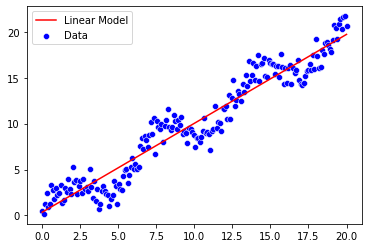

In [ ]:
sns.scatterplot(x=X, y=y, color="blue", label="Data")
sns.lineplot(x=X, y=y_pred.ravel(), color="red", label="Linear Model")

##A fully connected network

We can insert two linear layers one after the other.This is where the
`nn.Sequential` Module comes into play. This is a Module that takes a list or sequence of Modules as its input.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/02-fully-connected-networks/images/2.png?raw=1' width='600'/>



In [ ]:
# creates a new simple model that is a sequence of two nn.Linear layers
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 1)
)

train_network(model, loss_func, training_loader)

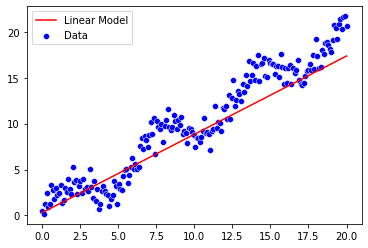

In [ ]:
# just plot our model’s prediction for all the data
with torch.no_grad():
  y_pred = model(torch.tensor(X.reshape(-1, 1), device="cpu", dtype=torch.float32)).cpu().numpy()

sns.scatterplot(x=X, y=y, color="blue", label="Data")
sns.lineplot(x=X, y=y_pred.ravel(), color="red", label="Linear Model")

As we can see, adding more layer did not help.

A little linear algebra will explain why this happened.

$$ f(x) = x^TW_{(h_1)}^{d, n}W_{out}^{n,C} $$

Where $W_{(h_1)}^{d, n}$ is hidden layer and $W_{out}^{n,C}$ is output layer.

But we can simplify the two weight matrices. If we have a matrix with shape `(a, b)` and a second matrix with shape `(b, c)` and we multiply
them together, we get a new matrix with shape `(a, c)`.

$$ W_{(h_1)}^{d, n}W_{out}^{n,C} = \tilde W_{d,c} $$

and therefore

$$ f(x)=x^TW_{(h_1)}^{d, n}W_{out}^{n,C} = x^T \tilde W_{d,c} $$

This shows that **adding any number of sequential linear layers is equivalent to using just one linear layer**. 

Linear operations beget(generate) linear operations and are usually redundant.


##Adding nonlinearities

To get any kind of benefit, we need to introduce nonlinearity between every step. By
inserting a nonlinear function after every linear operation, we allow the network to
build up more complex functions. We call nonlinear functions that are used this way
activation functions.

The tanh function is an historically popular nonlinearity. It maps everything into the range `[-1, 1]`:

$$ tanh(x) = \frac{sinhx}{coshx} = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

The sigmoid is the historical nonlinearity.It maps everything into the range `[0, 1]`:

$$ \sigma(x) = \frac{e^x}{e^x + 1} $$
Let’s quickly plot what these look like.

Text(0, 0.5, 'Activation')

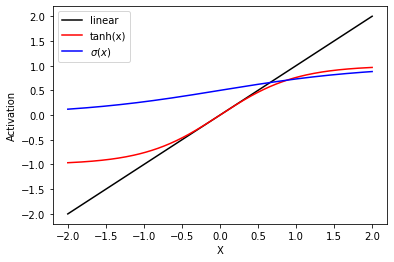

In [ ]:
activation_input = np.linspace(-2, 2, num=200)

tanh_activation = np.tanh(activation_input)
sigmoid_activation = np.exp(activation_input) / (np.exp(activation_input) + 1)

sns.lineplot(x=activation_input, y=activation_input, color="k", label="linear")
sns.lineplot(x=activation_input, y=tanh_activation, color="r", label="tanh(x)")

ax = sns.lineplot(x=activation_input, y=sigmoid_activation, color="b", label="$\sigma(x)$")
ax.set_xlabel("X")
ax.set_ylabel("Activation")

So, let’s use the tanh function.

$$ f(x)=tanh \left(x^TW_{d, n}^{(h_1)} \right)W_{n,C}^{out} $$

Let’s see what happens when we train this
new model:

In [ ]:
# creates a new simple model that is a sequence of two nn.Linear layers with tanh activation
model = nn.Sequential(
    nn.Linear(1, 10),   # Hidden layer
    nn.Tanh(),          # Activation
    nn.Linear(10, 1)    # Output layer
)

train_network(model, loss_func, training_loader, epochs=200)

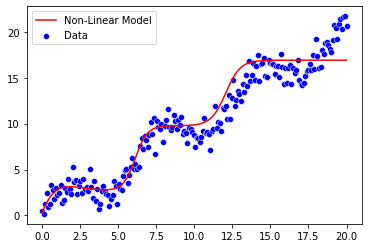

In [ ]:
# just plot our model’s prediction for all the data
with torch.no_grad():
  y_pred = model(torch.tensor(X.reshape(-1, 1), dtype=torch.float32)).cpu().numpy()

sns.scatterplot(x=X, y=y, color="blue", label="Data")
sns.lineplot(x=X, y=y_pred.ravel(), color="red", label="Non-Linear Model")

We can see that the network is now learning a nonlinear function, with bends that move
and adapt to match the data’s behavior.